In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

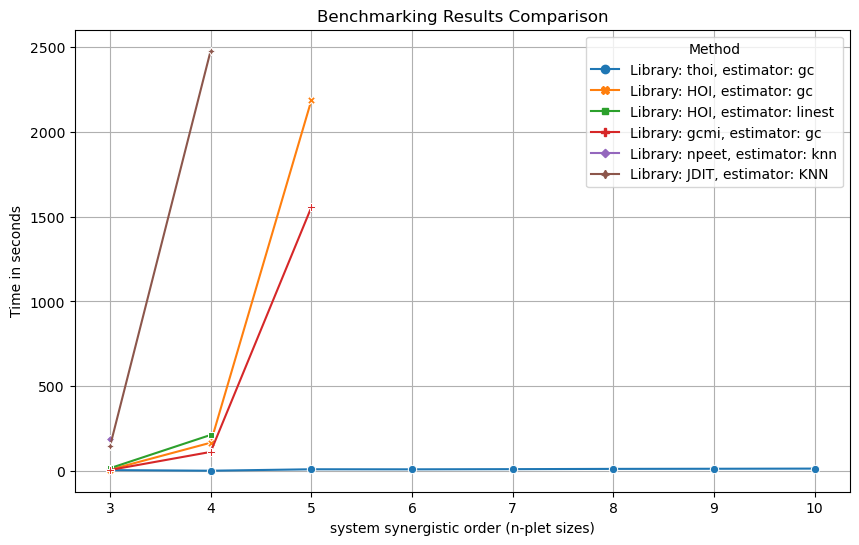

In [11]:
# Define the file paths
file_paths = [
    "library-thoi_estimator-gc.tsv",
    "library-hoi_estimator-gc.tsv",
    "library-hoi_estimator-linest.tsv",
    "library-gcmi_estimator-gc.tsv",
    "library-npeet_estimator-knn.tsv",
    "library-jdit_estimator-knn.tsv"
]

# Read each file into a DataFrame and assign a 'Method' column
dataframes = []
for path in file_paths:
    df = pd.read_csv(os.path.join('../benchmarking/results/times/',path), sep="\t")
    dataframes.append(df)

# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['library-estimator'] = 'Library: ' + combined_df['library'] + ', estimator: ' + combined_df['estimator']

# Create a line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=combined_df, x="order", y="time",
    hue="library-estimator", style='library-estimator',
    markers=True, dashes=False
)

plt.title('Benchmarking Results Comparison')
plt.xlabel('system synergistic order (n-plet sizes)')
plt.ylabel('Time in seconds')
plt.legend(title='Method')
plt.grid(True)
plt.show()

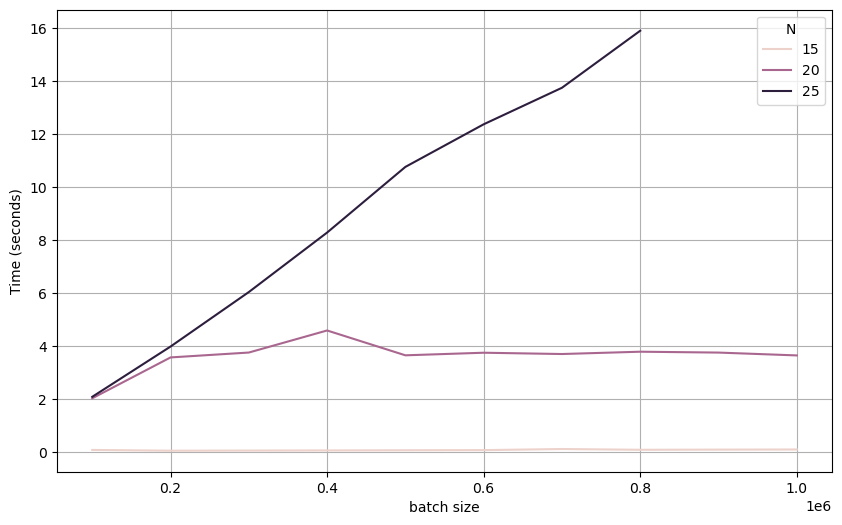

In [25]:
df = pd.read_csv('../benchmarking/results/times/new_library-thoi_estimator-gc.tsv', sep='\t')


# (df.N == 20) & 
df = df[(df['T'] == 1000) & (df.order == 10)]

# Create a line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df, x="batch_size", y="time",
    hue='N',
    markers=True, dashes=False
)

plt.xlabel('batch size')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()

In [20]:
#(df.N == 20) & (df.T == 1000) & (df.order == 10)

,library,estimator,T,N,batch_size,order,time
217,THOI,gc,1000,20,100000,10,2.039673
234,THOI,gc,1000,20,200000,10,3.580574
251,THOI,gc,1000,20,300000,10,3.764777
268,THOI,gc,1000,20,400000,10,4.596402
285,THOI,gc,1000,20,500000,10,3.660015
302,THOI,gc,1000,20,600000,10,3.757754
319,THOI,gc,1000,20,700000,10,3.708760
336,THOI,gc,1000,20,800000,10,3.796106
353,THOI,gc,1000,20,900000,10,3.763351
370,THOI,gc,1000,20,1000000,10,3.656098


In [18]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,457,458,459,460,461,462,463,464,465,466
library,THOI,THOI,THOI,THOI,THOI,THOI,THOI,THOI,THOI,THOI,...,THOI,THOI,THOI,THOI,THOI,THOI,THOI,THOI,THOI,THOI
estimator,gc,gc,gc,gc,gc,gc,gc,gc,gc,gc,...,gc,gc,gc,gc,gc,gc,gc,gc,gc,gc
T,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
N,5,5,5,5,5,5,5,5,5,5,...,25,25,25,25,25,25,25,25,25,25
batch_size,100000,100000,200000,200000,300000,300000,400000,400000,500000,500000,...,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000
order,3,4,3,4,3,4,3,4,3,4,...,8,9,10,11,12,13,14,15,16,17
time,5.818883,0.013273,0.015527,0.012868,0.018556,0.018675,0.024543,0.023866,0.029582,0.02949,...,9.531113,10.145755,10.763391,11.083104,11.97548,12.878098,13.671265,14.815907,16.257763,17.234323
